In [ ]:
!pip install pyarabic

In [ ]:
import pandas as pd
import tensorflow as tf
import re
import pyarabic.araby as araby
import nltk
from nltk.corpus import stopwords
import numpy as np
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pyarabic.araby as araby
import nltk
from sklearn.utils import resample
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

from sklearn import model_selection, preprocessing, linear_model, naive_bayes, metrics, svm
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn import decomposition, ensemble

from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score

In [ ]:
# Mounting Google Drive to load data

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Reading and Exploration

In [ ]:
# Labeled tweets filtering

df = pd.read_csv('/content/drive/My Drive/Upwork/Racism/Dataset.csv')
print(f'Total number of tweeets: {df.shape[0]}')

df.drop_duplicates(subset='Tweet', keep='first',inplace=True) # Remove duplicated tweets
df.dropna(subset=['Tweet'],inplace=True) # Remove duplicated tweets
print(f'Number of unique tweets: {df.shape[0]}')

Total number of tweeets: 10971
Number of unique tweets: 10950


In [ ]:
df.head()

,Tweet,Label
0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0
1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0
2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0
3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0
4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1


In [ ]:
df.Label.unique()

array([0, 1])

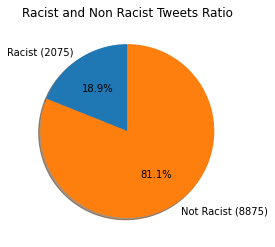

In [ ]:
#Plotting the number of  Racist vs not-Racist tweets
df.Label = pd.to_numeric(df.Label)

racist = sum(df.Label==1)
not_racist = sum(df.Label==0)

# Pie chart, where the slices will be ordered and plotted counter-clockwise:
labels = 'Racist '+'('+str(racist)+')', 'Not Racist '+'('+str(not_racist)+')'
sizes = [racist, not_racist]

fig1, ax1 = plt.subplots()
ax1.pie(sizes, labels=labels, autopct='%1.1f%%',
        shadow=True, startangle=90)
plt.title('Racist and Non Racist Tweets Ratio')
plt.show()

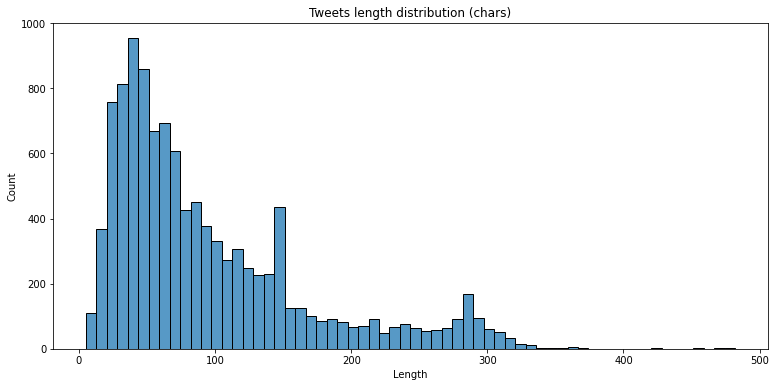

In [ ]:
df['Length'] = df['Tweet'].str.len()
plt.figure(figsize=(12.8,6))
plt.title('Tweets length distribution (chars)')
sns.histplot(df['Length']);

# Data Pre-Processing

In [ ]:
# Removing non-Arabice characters and symbols

df['Cleaned_1'] = df['Tweet'].map(lambda s: re.findall(r'[\u0600-\u06FF]+', s))
df['Cleaned_1']  = df['Cleaned_1'].map(lambda s: str(s).replace(",", "").replace("'",'').replace("[",'').replace("]",''))
df.head(5)

,Tweet,Label,Length,Cleaned_1
0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0,56,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...
1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0,193,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...
2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0,71,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...
3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0,228,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...
4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1,145,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...


In [ ]:
# Cleaning text from non-Arabic characters, links, symbols, or emojis

df['Cleaned_2'] = df['Cleaned_1'].str.replace("\r", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("http[s]?://[a-zA-Z0-9_\-./~\?=%&]+", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("www[a-zA-Z0-9_\-?=%&/.~]+", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("[a-zA-Z]+\.org", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("://", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("[a-zA-Z]+\.com", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("&[^;]+;", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("\s+", " ")
df['Cleaned_2'] = df['Cleaned_2'].str.replace("ـ", "")             # remove  ـــ char like اســــــم

df.head(10)

,Tweet,Label,Length,Cleaned_1,Cleaned_2
0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0,56,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...
1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0,193,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...
2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0,71,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...
3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0,228,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...
4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1,145,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...
5,'كل التضامن مع الشعب السوداني الشقيق لتجاوز م...,0,249,كل التضامن مع الشعب السوداني الشقيق لتجاوز محن...,كل التضامن مع الشعب السوداني الشقيق لتجاوز محن...
6,'تصبحون على م تتمنون ♥️'),0,26,تصبحون على م تتمنون,تصبحون على م تتمنون
7,"'RT @ELHeksos_nakba: ""إحنا المصريين الأرمن""!!...",0,147,إحنا المصريين الأرمن بكرة يتقال إحنا المصريين ...,إحنا المصريين الأرمن بكرة يتقال إحنا المصريين ...
8,'ما أبي باكر بدونك'),0,21,ما أبي باكر بدونك,ما أبي باكر بدونك
9,'@Camrela ازيدك من الشعر بيت بعضهم يجحدك 😂'),0,45,ازيدك من الشعر بيت بعضهم يجحدك,ازيدك من الشعر بيت بعضهم يجحدك


In [ ]:
# df.to_excel('cleaned_2.xlsx', index=False, header=None)

In [ ]:
# Removing Punctuation and "tashkeel"

punctuation_signs = list("?:!.,;؟،")

for punct_sign in punctuation_signs:
    df['Cleaned_2'] = df['Cleaned_1'].str.replace(punct_sign, ' ')

df['Cleaned_3'] = df['Cleaned_2'].str.replace("\s+", " ")             # remove  spaces

df['Cleaned_3'] = df['Cleaned_3'].apply(araby.strip_tashkeel) #remove any تشكيل
df['Cleaned_3'] = df['Cleaned_3'].str.replace("[أإآ]", "ا") #normalize همزة
df['Cleaned_3'] = df['Cleaned_3'].str.replace("ى", "ي") #normalize ي,ى
df['Cleaned_3'] = df['Cleaned_3'].str.replace("ة", "ه") #normalize ة,ه

df.head(5)

,Tweet,Label,Length,Cleaned_1,Cleaned_2,Cleaned_3
0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0,56,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...,لستُ بِمن يدبر المكائد والمؤامرات وأنا بِهذا ...,لست بمن يدبر المكائد والمؤامرات وانا بهذا فخور
1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0,193,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء ان تقضي حياتك في تتبع ارضاء فلان وفل...
2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0,71,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...
3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0,228,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...
4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1,145,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراه ولا الانجيل ولا بوذا انا مسلم و...


In [ ]:
# Removing repeated consecutive chars (more than 2)

def remove_repeating_char(text):
    return re.sub(r'(.)\1{2,}', r'\1', text)     # if we have 3 or more repeated chars keep only 1 repeat but if 2 leave it.
# so it replaces "كتاااااااااب" with "كتاب"
# but leaves "تتمحور" as it is.
df['Cleaned_3'] = df['Cleaned_3']
df['Cleaned_3'] = df['Cleaned_3'].apply(remove_repeating_char) #remove any repeating chars

df.head(5)

,Tweet,Label,Length,Cleaned_1,Cleaned_2,Cleaned_3
0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0,56,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...,لستُ بِمن يدبر المكائد والمؤامرات وأنا بِهذا ...,لست بمن يدبر المكائد والمؤامرات وانا بهذا فخور
1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0,193,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء ان تقضي حياتك في تتبع ارضاء فلان وفل...
2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0,71,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...
3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0,228,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...
4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1,145,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراه ولا الانجيل ولا بوذا انا مسلم و...


In [ ]:
# Loading Arabic stop-words
nltk.download('stopwords')
stop_words = list(stopwords.words('arabic'))
stop_words = [s.replace("أ", "ا").replace("إ", "ا").replace("آ", "ا") for s in stop_words] #normalize همزة
print(stop_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
['اذ', 'اذا', 'اذما', 'اذن', 'اف', 'اقل', 'اكثر', 'الا', 'الا', 'التي', 'الذي', 'الذين', 'اللاتي', 'اللائي', 'اللتان', 'اللتيا', 'اللتين', 'اللذان', 'اللذين', 'اللواتي', 'الى', 'اليك', 'اليكم', 'اليكما', 'اليكن', 'ام', 'اما', 'اما', 'اما', 'ان', 'ان', 'انا', 'انا', 'انت', 'انتم', 'انتما', 'انتن', 'انما', 'انه', 'انى', 'انى', 'اه', 'اها', 'او', 'اولاء', 'اولئك', 'اوه', 'اي', 'اي', 'ايها', 'اي', 'اين', 'اين', 'اينما', 'ايه', 'بخ', 'بس', 'بعد', 'بعض', 'بك', 'بكم', 'بكم', 'بكما', 'بكن', 'بل', 'بلى', 'بما', 'بماذا', 'بمن', 'بنا', 'به', 'بها', 'بهم', 'بهما', 'بهن', 'بي', 'بين', 'بيد', 'تلك', 'تلكم', 'تلكما', 'ته', 'تي', 'تين', 'تينك', 'ثم', 'ثمة', 'حاشا', 'حبذا', 'حتى', 'حيث', 'حيثما', 'حين', 'خلا', 'دون', 'ذا', 'ذات', 'ذاك', 'ذان', 'ذانك', 'ذلك', 'ذلكم', 'ذلكما', 'ذلكن', 'ذه', 'ذو', 'ذوا', 'ذواتا', 'ذواتي', 'ذي', 'ذين', 'ذينك', 'ريث', 'سوف', 'سوى', 'شتان', 'عدا', 'عسى', 'عل

In [ ]:
# Removing stop-words

df['Cleaned_4'] = df['Cleaned_3']
for stop_word in stop_words:
    regex_stopword = r"\b" + stop_word + r"\b"
    df['Cleaned_4'] = df['Cleaned_4'].str.replace(regex_stopword, '')
df.reset_index(inplace=True)
df.head(5)

,index,Tweet,Label,Length,Cleaned_1,Cleaned_2,Cleaned_3,Cleaned_4
0,0,'لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذ...,0,56,لستُ بِمن يدبر المكائد والمؤامرات، وأنا بِهذا ...,لستُ بِمن يدبر المكائد والمؤامرات وأنا بِهذا ...,لست بمن يدبر المكائد والمؤامرات وانا بهذا فخور,يدبر المكائد والمؤامرات وانا بهذا فخور
1,1,'كل الغباء أن تقضي حياتك في تتبع إرضاء فلان و...,0,193,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء أن تقضي حياتك في تتبع إرضاء فلان وفل...,كل الغباء ان تقضي حياتك في تتبع ارضاء فلان وفل...,الغباء تقضي حياتك تتبع ارضاء فلان وفلان افع...
2,2,'@abodealii38 ان ام دي مرا حلو لونها ماجيك يت...,0,71,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,ان ام دي مرا حلو لونها ماجيك يتغير كدا بس مو م...,دي مرا حلو لونها ماجيك يتغير كدا مو مرا مريحه
3,3,'@alosmlly بقايا لا ارث لهم ولا تاريخ جعلوا م...,0,228,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا لا ارث لهم ولا تاريخ جعلوا من اسمهم لهم ...,بقايا ارث تاريخ جعلوا اسمهم مجيد وتاريخ و...
4,4,'@e_a7md @MBS_ST @abeer70120600 @fdeet_alnssr...,1,145,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراة ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراه ولا الانجيل ولا بوذا انا مسلم و...,مااعرف التوراه الانجيل بوذا مسلم واعرف قرا...


In [ ]:
#Sample of the final cleaned tweets
import random
for i in range(30):
    n = random.randint(0, len(df))
    if df['Cleaned_4'][n]:
        print(f"{i}: {df['Cleaned_4'][n].strip()}")

1: تفكر كثيرا  استغفر كثيرا ؛ فالله يفتح بالاستغفار ابوابا  تفتح بالتفكير استغفرالله استغفرالله استغفرالله
2: التضامن  الشعب السوداني الشقيق لتجاوز محنته اثر السيول والفيضانات  اجتاحته واسفرت  خسائر  الارواح وخالص تعازينا ومواساتنا الي اسر الضحايا وتمنياتنا بالشفاء العاجل للمصابين والسلامه لـ السودان نقف  السودان  قلبي سلام للخرطوم
3: الان  كامل انطفائي
4: وابوها يذبحها
5: سمحت
6: باذن الله فوز للاصفر الكبير الاتحاد النصر
7: شي
8: اللي فرط بالاقصي  الفلسطز انفسهم عندما باعوها لليهود  العشرينات و الثلاثينات ووالدك مصطفي ريان   كبا
9: جوليانو بيتروس موسي استمرار  الثلاثي كارثه الاتحاد النصر
10: الاول الجلاد
11: جالس  اخوي وقت مانزلت الصور ويقولي اول صوره تصورها وتطلع حلوه
12: دوم
13: يمبسطون  انهوا مسلسل عشان يبدؤون بواحد ثاني وانا امبسط  انهيته عشان ارجع لافضل حوارات المسلسل واحفظها
14: السلام عليكم ممكن تردين خاص
15: هاي انجازات حكومه العتاكه الهمج الي مو كادرين يحمون العراق ويحجون علي صدام
16: دائما وابدا انشالله
17: بنات ويش فيكم
18: باعو الكضيه والهويه حتي لحفادهم يبحثون  المتاجره ف

In [ ]:
short_cleaned_tweets = sum([1 for i in df.Cleaned_4.str.split() if len(i) < 3])
short_cleaned_tweets

1740

In [ ]:
# numbers of Rows and Columns
df.shape

(10950, 8)

In [ ]:
from sklearn.model_selection import train_test_split
# Splitting data to train and test sets
df.Labels = pd.to_numeric(df.Label)
X_train, X_test, y_train, y_test = train_test_split(df['Cleaned_4'],
                                                    df['Label'],
                                                    test_size=0.2,
                                                    random_state=0)
X_train, X_val, y_train, y_val = train_test_split(X_train,
                                                    y_train,
                                                    test_size=0.125,
                                                    random_state=0)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(7665,)
(2190,)
(1095,)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
# Separate majority and minority classes
df_majority = X_train[y_train==0]
df_minority = X_train[y_train==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=0) # reproducible results

# Combine majority class with upsampled minority class
y_train_upsampled = np.concatenate((np.zeros_like(df_majority),np.ones_like(df_minority_upsampled)))
y_train_upsampled = y_train_upsampled.astype('int')
X_train_upsampled = pd.concat([df_majority, df_minority_upsampled]).values

# Display new class counts
print(len(df_minority_upsampled))
print(len(X_train_upsampled))

6187
12374


In [ ]:
y_test = y_test.astype('int')
y_val = y_val.astype('int')

# Machine Learning


In [ ]:
# Separate majority and minority classes
df_majority = X_train[y_train==0]
df_minority = X_train[y_train==1]

# Upsample minority class
df_minority_upsampled = resample(df_minority,
                                 replace=True,     # sample with replacement
                                 n_samples=len(df_majority),    # to match majority class
                                 random_state=0) # reproducible results

# Combine majority class with upsampled minority class
y_train_upsampled = np.concatenate((np.zeros_like(df_majority),np.ones_like(df_minority_upsampled)))
y_train_upsampled = y_train_upsampled.astype('int')
X_train_upsampled = pd.concat([df_majority, df_minority_upsampled]).values
y_test=y_test.astype('int')


print(len(df_minority_upsampled))
print(len(df_majority))

6187
6187


In [ ]:
# Feature Extraction

# word level tf-idf
tfidf_vect = TfidfVectorizer(analyzer='word', strip_accents='unicode', binary=True)
tfidf_vect.fit(X_train_upsampled)
xtrain_tfidf =  tfidf_vect.transform(X_train_upsampled)
xvalid_tfidf =  tfidf_vect.transform(X_test.values)

In [ ]:
xtrain_tfidf.shape

(12374, 29805)

In [ ]:
y_train_upsampled.shape

(12374,)

In [ ]:
# All paramaters are determined by trial and error except for SVC - used a Gird Search -

svc = SVC(kernel='rbf', C=3, gamma='scale')
knc = KNeighborsClassifier(n_neighbors=3)
mnb = MultinomialNB(alpha=0.4)
dtc = DecisionTreeClassifier(min_samples_split=17, random_state=0)
rfc = RandomForestClassifier(n_estimators = 39, min_samples_split=39, bootstrap=True, criterion='entropy')


clfs = {'SVC' : svc,'KN' : knc, 'MNB': mnb, 'DT': dtc, 'RF': rfc}


def train_model(classifier, feature_vector_train, label, feature_vector_valid, valid_y, is_neural_net=False):
    # fit the training dataset on the classifier
    classifier.fit(feature_vector_train, label)

    # predict the labels on validation dataset
    predictions = classifier.predict(feature_vector_valid)

    if is_neural_net:
        predictions = predictions.argmax(axis=-1)

    return metrics.accuracy_score(predictions, valid_y), classifier

In [ ]:
################################################################################################
#### Here, We will optimize for 2 metrics (Accuracy and Precision) as we want to correctly  ####
### classify as many tweets as possible (Accuracy) with the concern that we want as many as ####
### correct classified positive (depressed) tweets as possible (Precision). ####################
################################################################################################
#

def train_classifier(clf, X_train, y_train):
    clf.fit(X_train, y_train)
def predict_labels(clf, X_test):
    return (clf.predict(X_test))


pred_scores = []
preds = []
for k,v in clfs.items():
    train_classifier(v, xtrain_tfidf, y_train_upsampled)
    pred = predict_labels(v, xvalid_tfidf)
    preds.append(pred)
    pred_scores.append((k, accuracy_score(y_test,pred), precision_score(y_test,pred), recall_score(y_test,pred), f1_score(y_test,pred), metrics.roc_auc_score(y_test,pred)))
scores_tfidf = pd.DataFrame(pred_scores, columns=['Model', 'Accuracy Score', 'Precision Score','Recall Score', 'F1 Score', 'AUC Score'])
scores_tfidf

,Model,Accuracy Score,Precision Score,Recall Score,F1 Score,AUC Score
0,SVC,0.934703,0.882857,0.751825,0.812089,0.864389
1,KN,0.832877,0.764706,0.158151,0.262097,0.573454
2,MNB,0.852055,0.566210,0.905109,0.696629,0.872454
3,DT,0.943836,0.809013,0.917275,0.859749,0.933623
4,RF,0.932420,0.773389,0.905109,0.834081,0.921920


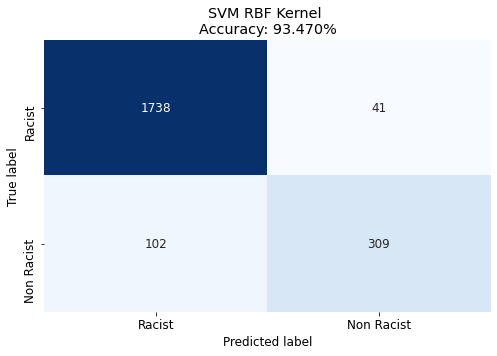

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix
class_names = ['Racist', 'Non Racist']
classifier_index = 0

# Creates a confusion matrix
cm = confusion_matrix(y_test, preds[classifier_index])
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names,
                     columns = class_names)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.title('SVM RBF Kernel \nAccuracy: {0:.3f}%'.format(scores_tfidf['Accuracy Score'][classifier_index]*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.rcParams['font.size'] = 12
plt.show()

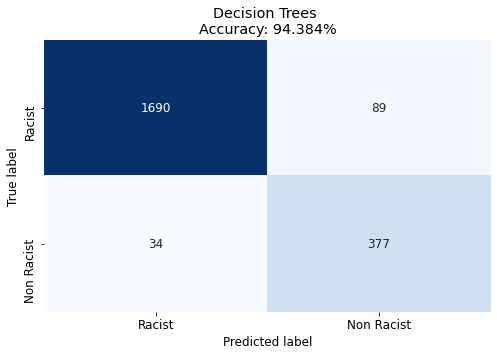

In [ ]:
classifier_index = 3

# Creates a confusion matrix
cm = confusion_matrix(y_test, preds[classifier_index])
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names,
                     columns = class_names)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.title('Decision Trees \nAccuracy: {0:.3f}%'.format(scores_tfidf['Accuracy Score'][classifier_index]*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.rcParams['font.size'] = 12
plt.show()

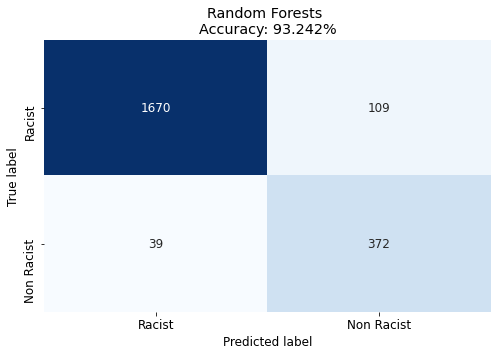

In [ ]:
classifier_index = 4

# Creates a confusion matrix
cm = confusion_matrix(y_test, preds[classifier_index])
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = class_names,
                     columns = class_names)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.title('Random Forests \nAccuracy: {0:.3f}%'.format(scores_tfidf['Accuracy Score'][classifier_index]*100))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.rcParams['font.size'] = 12
plt.show()

In [ ]:
# Predictions on a random sample tweets
clf = dtc.fit(xtrain_tfidf, y_train_upsampled)
predictions = clf.predict(xvalid_tfidf)
mapping = ['Not Racist', 'Racist']
for i in range(10):
    n = random.randint(0, len(X_test))
    print(f'Tweet: {df.Tweet.iloc[n]}')
    print(f'Cleaned Tweet: {df.Cleaned_4.iloc[n]}')
    print(f'Predicted Label: {mapping[predictions[n]]}')
    print()

Tweet:  '@jamalrayyan هههههه قال وش شهودك ياثعلب قال ذيلي ..\nماطقع من سعد السفية الزبيري المشرد الا جمال خربان الفلسطيزي المرتزق ..')
Cleaned Tweet: ه قال وش شهودك ياثعلب قال ذيلي ماطقع  سعد السفيه الزبيري المشرد  جمال خربان الفلسطيزي المرتزق
Predicted Label: Not Racist

Tweet:  '@Juhaieeem الفلسطز اخذوا اكبر من حجمهم بزياده')
Cleaned Tweet: الفلسطز اخذوا اكبر  حجمهم بزياده
Predicted Label: Not Racist

Tweet:  'امبيه صح والله🙃')
Cleaned Tweet: امبيه صح والله
Predicted Label: Not Racist

Tweet:  'كل صوره واحنا بنتخانق ♥️♥️♥️ https://t.co/0LNElfG2zt')
Cleaned Tweet:  صوره واحنا بنتخانق
Predicted Label: Not Racist

Tweet:  'طلعه بعنوان تعالو نتفشل بسبب حمود واسكريمنا الذايب')
Cleaned Tweet: طلعه بعنوان تعالو نتفشل بسبب حمود واسكريمنا الذايب
Predicted Label: Not Racist

Tweet:  'رفيق الرحلة\nالأنيق عبدالله المتعب 🎗 https://t.co/6fmmmriyYq')
Cleaned Tweet: رفيق الرحله الانيق عبدالله المتعب
Predicted Label: Not Racist

Tweet:  'نص ساعه وحدها بس تفصلنا😭♥️♥️\n\n#WONHO_OpenMind_MV')
Cleaned Tw

# Deep Learning

In [ ]:
import keras.backend
from keras.models import Sequential, load_model
from keras.layers import Dense, Conv1D, MaxPooling1D
from keras.layers import Dropout, GlobalMaxPooling1D, BatchNormalization, LSTM
from keras.layers import Bidirectional
from keras.layers.embeddings import Embedding
from keras.optimizers import Nadam
from keras.utils.vis_utils import plot_model
from keras.preprocessing.text import text_to_word_sequence
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.layers import Dropout, Activation, MaxPooling1D, Flatten
from keras.layers import Embedding
from keras.layers import GlobalMaxPooling1D
from keras.callbacks import EarlyStopping
from keras.regularizers import l2
from sklearn import metrics

In [ ]:
# Transfer sentences to Words
tokenizer = Tokenizer(num_words=None,split=' ',char_level=False)
X = df['Cleaned_4']
tokenizer.fit_on_texts(X)

In [ ]:
# To Determine the best lenght of the tweet
word_index = tokenizer.word_index
vocab_size = len(word_index)
print('Vocab size: {}'.format(vocab_size))
longest = max(len(seq) for seq in X)
print("Longest tweet size: {}".format(longest))
average = np.mean([len(seq) for seq in X])
print("Average tweet size: {}".format(average))
stdev = np.std([len(seq) for seq in X])
print("Stdev of tweet size: {}".format(stdev))
max_len = int(average + stdev * 3)
print('Max tweet size: {}'.format(max_len))

Vocab size: 38156
Longest tweet size: 275
Average tweet size: 64.59716894977169
Stdev of tweet size: 62.44750132078063
Max tweet size: 251


In [ ]:
# reading the vectors file
embeddings_index = {}
f = open('/content/drive/My Drive/Upwork/Racism/vectors.txt')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()
print('Found %s word vectors.' % len(embeddings_index))

Found 1538616 word vectors.


In [ ]:
# converting each word into embedding vector (Arabic embedding)
embedding_dim = 256
k = 0
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # Words not found in embedding index will be all-zeros.
        k += 1
        embedding_matrix[i] = embedding_vector

### Before upsampling

In [ ]:
x_train = tokenizer.texts_to_sequences(X_train)
x_test = tokenizer.texts_to_sequences(X_test)
x_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
processed_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
processed_x_val = pad_sequences(x_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)
print('x_val shape:', processed_x_val.shape)

x_train shape: (7665, 251)
x_test shape: (2190, 251)
x_val shape: (1095, 251)


In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(60, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 60)           76080     
_________________________________________________________________
conv1d (Conv1D)              (None, 251, 32)           13472     
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d (Global (None, 32)                0         
_________________________________________________________________
batch_normalization (BatchNo (None, 32)                128       
_________________________________________________________________
dense (Dense)                (None, 64)                2

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
120/120 [==============================] - 49s 121ms/step - loss: 11.8577 - auc: 0.6083 - val_loss: 3.6811 - val_auc: 0.8998
Epoch 2/10
120/120 [==============================] - 14s 113ms/step - loss: 2.6074 - auc: 0.9266 - val_loss: 0.8712 - val_auc: 0.9498
Epoch 3/10
120/120 [==============================] - 14s 113ms/step - loss: 0.6196 - auc: 0.9825 - val_loss: 0.4413 - val_auc: 0.9426
Epoch 4/10
120/120 [==============================] - 14s 114ms/step - loss: 0.2469 - auc: 0.9955 - val_loss: 0.3538 - val_auc: 0.9378
Epoch 5/10
120/120 [==============================] - 13s 112ms/step - loss: 0.1871 - auc: 0.9949 - val_loss: 0.3554 - val_auc: 0.9389
Epoch 6/10
120/120 [==============================] - 13s 111ms/step - loss: 0.1553 - auc: 0.9970 - val_loss: 0.3841 - val_auc: 0.9349
Epoch 7/10
120/120 [==============================] - 13s 112ms/step - loss: 0.1861 - auc: 0.9897 - val_loss: 0.3749 - val_auc: 0.9261
Epoch 8/10
120/120 [==============================] - 

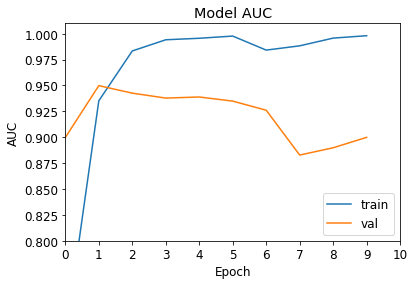

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.94      0.95      1779
      Racist       0.77      0.80      0.79       411

    accuracy                           0.92      2190
   macro avg       0.86      0.87      0.87      2190
weighted avg       0.92      0.92      0.92      2190

Test Accuracy: 90.72%
Test AUC: 87.39%


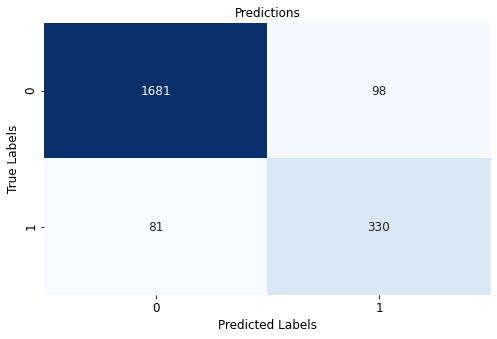

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### After upsampling

In [ ]:
x_train = tokenizer.texts_to_sequences(X_train_upsampled)
x_test = tokenizer.texts_to_sequences(X_test)
x_val = tokenizer.texts_to_sequences(X_val)

In [ ]:
from keras.preprocessing.sequence import pad_sequences
processed_x_train = pad_sequences(x_train, maxlen=max_len, padding='post', truncating='post')
processed_x_test = pad_sequences(x_test, maxlen=max_len, padding='post', truncating='post')
processed_x_val = pad_sequences(x_val, maxlen=max_len, padding='post', truncating='post')

In [ ]:
print('x_train shape:', processed_x_train.shape)
print('x_test shape:', processed_x_test.shape)
print('x_val shape:', processed_x_val.shape)

x_train shape: (12374, 251)
x_test shape: (2190, 251)
x_val shape: (1095, 251)


# Trying the AUC metric instead of the Accuracy.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(60, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 60)           76080     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 251, 32)           13472     
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
dense_3 (Dense)              (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 25s 117ms/step - loss: 10.1183 - auc: 0.7637 - val_loss: 1.5294 - val_auc: 0.9486
Epoch 2/10
194/194 [==============================] - 22s 114ms/step - loss: 0.8669 - auc: 0.9879 - val_loss: 0.3913 - val_auc: 0.9424
Epoch 3/10
194/194 [==============================] - 22s 114ms/step - loss: 0.2130 - auc: 0.9970 - val_loss: 0.3585 - val_auc: 0.9384
Epoch 4/10
194/194 [==============================] - 22s 114ms/step - loss: 0.1575 - auc: 0.9983 - val_loss: 0.3724 - val_auc: 0.9230
Epoch 5/10
194/194 [==============================] - 22s 114ms/step - loss: 0.1375 - auc: 0.9985 - val_loss: 0.3487 - val_auc: 0.9191
Epoch 6/10
194/194 [==============================] - 22s 115ms/step - loss: 0.1205 - auc: 0.9991 - val_loss: 0.3454 - val_auc: 0.9326
Epoch 7/10
194/194 [==============================] - 22s 113ms/step - loss: 0.1082 - auc: 0.9994 - val_loss: 0.3700 - val_auc: 0.9059
Epoch 8/10
194/194 [==============================] - 

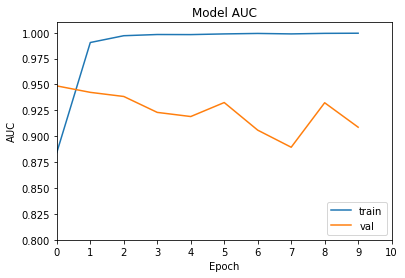

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.95      0.95      1779
      Racist       0.80      0.80      0.80       411

    accuracy                           0.92      2190
   macro avg       0.87      0.88      0.88      2190
weighted avg       0.92      0.92      0.92      2190

Test Accuracy: 91.35%
Test AUC: 87.54%


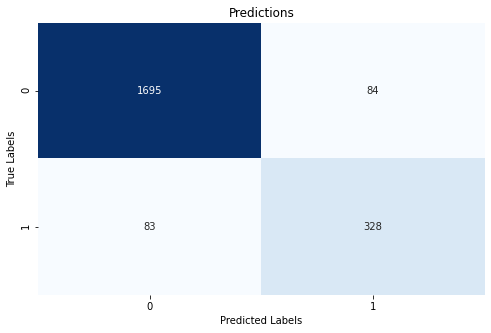

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

# Experimenting with different LSTM neurons numbers.

### 1 LSTM neuron and 1 dense layer.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(1, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=1, kernel_size=1, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(1)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 1)            1032      
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 251, 1)            2         
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 251, 1)            0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 1)                 0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 1)                 4         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 23s 107ms/step - loss: 0.6484 - auc: 0.7183 - val_loss: 0.5817 - val_auc: 0.9411
Epoch 2/10
194/194 [==============================] - 20s 104ms/step - loss: 0.4494 - auc: 0.9844 - val_loss: 0.3935 - val_auc: 0.9502
Epoch 3/10
194/194 [==============================] - 20s 104ms/step - loss: 0.3027 - auc: 0.9934 - val_loss: 0.3016 - val_auc: 0.9507
Epoch 4/10
194/194 [==============================] - 20s 104ms/step - loss: 0.2046 - auc: 0.9954 - val_loss: 0.2631 - val_auc: 0.9450
Epoch 5/10
194/194 [==============================] - 20s 105ms/step - loss: 0.1431 - auc: 0.9961 - val_loss: 0.2382 - val_auc: 0.9400
Epoch 6/10
194/194 [==============================] - 20s 105ms/step - loss: 0.1063 - auc: 0.9956 - val_loss: 0.2235 - val_auc: 0.9399
Epoch 7/10
194/194 [==============================] - 20s 103ms/step - loss: 0.0806 - auc: 0.9969 - val_loss: 0.2289 - val_auc: 0.9302
Epoch 8/10
194/194 [==============================] - 2

In [ ]:
history.history

{'auc': [0.8665237426757812,
  0.9867997169494629,
  0.993165135383606,
  0.9947104454040527,
  0.9951143264770508,
  0.9958229660987854,
  0.9957189559936523,
  0.9958524107933044,
  0.996309757232666,
  0.9964116811752319],
 'loss': [0.5976983308792114,
  0.4119691848754883,
  0.2783879339694977,
  0.18841257691383362,
  0.1347980499267578,
  0.10074508190155029,
  0.07935696840286255,
  0.06573496013879776,
  0.055952418595552444,
  0.04878544807434082],
 'val_auc': [0.9411293864250183,
  0.9502348899841309,
  0.9506546854972839,
  0.9450182914733887,
  0.93998783826828,
  0.9399434924125671,
  0.9301548004150391,
  0.9350314140319824,
  0.9346618056297302,
  0.9435543417930603],
 'val_loss': [0.5816922783851624,
  0.39348387718200684,
  0.30164656043052673,
  0.263113409280777,
  0.23818959295749664,
  0.2235468626022339,
  0.22886528074741364,
  0.23004212975502014,
  0.2321179360151291,
  0.2243983894586563]}

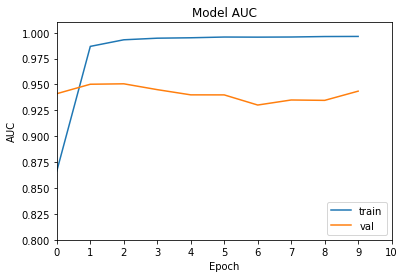

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.96      0.96      0.96      1779
      Racist       0.81      0.82      0.82       411

    accuracy                           0.93      2190
   macro avg       0.88      0.89      0.89      2190
weighted avg       0.93      0.93      0.93      2190

Test Accuracy: 93.20%
Test AUC: 88.99%


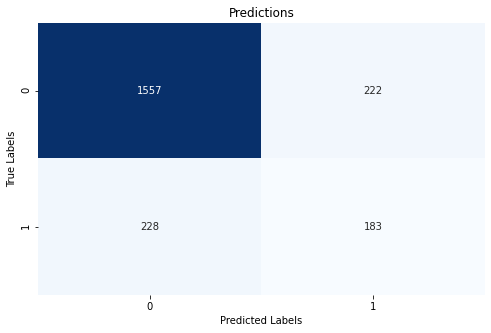

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 30-neurons LSTM.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(30, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 30)           34440     
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 251, 32)           6752      
_________________________________________________________________
max_pooling1d_3 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_3 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 32)                128       
_________________________________________________________________
dense_7 (Dense)              (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 25s 118ms/step - loss: 10.1325 - auc: 0.7392 - val_loss: 1.6416 - val_auc: 0.9473
Epoch 2/10
194/194 [==============================] - 22s 113ms/step - loss: 0.8709 - auc: 0.9887 - val_loss: 0.3630 - val_auc: 0.9516
Epoch 3/10
194/194 [==============================] - 22s 113ms/step - loss: 0.2126 - auc: 0.9982 - val_loss: 0.3183 - val_auc: 0.9557
Epoch 4/10
194/194 [==============================] - 22s 113ms/step - loss: 0.1572 - auc: 0.9993 - val_loss: 0.3142 - val_auc: 0.9522
Epoch 5/10
194/194 [==============================] - 22s 114ms/step - loss: 0.1360 - auc: 0.9991 - val_loss: 0.3341 - val_auc: 0.9402
Epoch 6/10
194/194 [==============================] - 22s 114ms/step - loss: 0.1201 - auc: 0.9996 - val_loss: 0.3195 - val_auc: 0.9510
Epoch 7/10
194/194 [==============================] - 22s 114ms/step - loss: 0.1110 - auc: 0.9992 - val_loss: 0.3678 - val_auc: 0.9285
Epoch 8/10
194/194 [==============================] - 

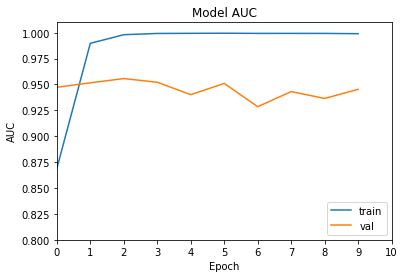

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.95      0.95      1779
      Racist       0.80      0.81      0.80       411

    accuracy                           0.93      2190
   macro avg       0.88      0.88      0.88      2190
weighted avg       0.93      0.93      0.93      2190

Test Accuracy: 94.05%
Test AUC: 87.91%


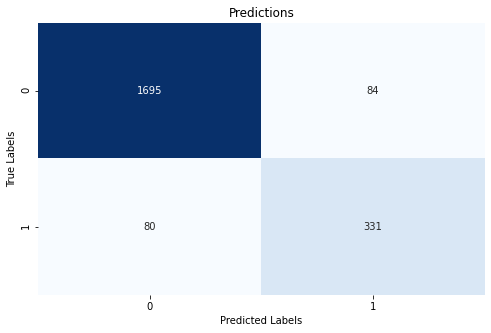

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 100-neurons LSTM.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_4 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_4 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_4 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 32)                128       
_________________________________________________________________
dense_10 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 27s 127ms/step - loss: 9.8432 - auc: 0.7838 - val_loss: 1.3796 - val_auc: 0.9464
Epoch 2/10
194/194 [==============================] - 24s 124ms/step - loss: 0.8439 - auc: 0.9858 - val_loss: 0.3926 - val_auc: 0.9444
Epoch 3/10
194/194 [==============================] - 24s 123ms/step - loss: 0.2211 - auc: 0.9958 - val_loss: 0.3376 - val_auc: 0.9441
Epoch 4/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1642 - auc: 0.9977 - val_loss: 0.3647 - val_auc: 0.9428
Epoch 5/10
194/194 [==============================] - 24s 124ms/step - loss: 0.1400 - auc: 0.9986 - val_loss: 0.3318 - val_auc: 0.9452
Epoch 6/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1245 - auc: 0.9990 - val_loss: 0.3593 - val_auc: 0.9294
Epoch 7/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1104 - auc: 0.9993 - val_loss: 0.3676 - val_auc: 0.9410
Epoch 8/10
194/194 [==============================] - 2

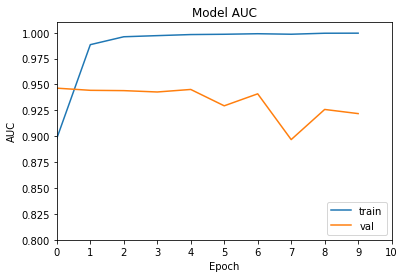

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.95      0.95      1779
      Racist       0.78      0.76      0.77       411

    accuracy                           0.91      2190
   macro avg       0.86      0.86      0.86      2190
weighted avg       0.91      0.91      0.91      2190

Test Accuracy: 92.75%
Test AUC: 85.55%


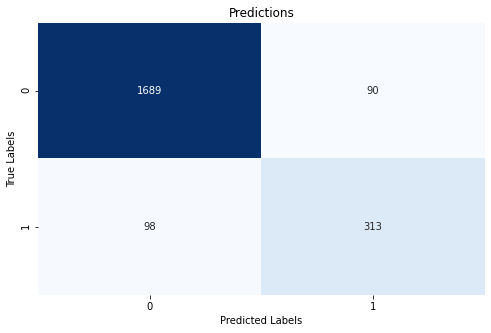

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 150-neurons LSTM.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(150, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_5 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 150)          244200    
_________________________________________________________________
conv1d_5 (Conv1D)            (None, 251, 32)           33632     
_________________________________________________________________
max_pooling1d_5 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_5 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 32)                128       
_________________________________________________________________
dense_13 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 28s 133ms/step - loss: 9.8196 - auc: 0.7961 - val_loss: 1.4127 - val_auc: 0.9492
Epoch 2/10
194/194 [==============================] - 25s 130ms/step - loss: 0.8510 - auc: 0.9851 - val_loss: 0.3798 - val_auc: 0.9482
Epoch 3/10
194/194 [==============================] - 25s 130ms/step - loss: 0.2205 - auc: 0.9979 - val_loss: 0.3418 - val_auc: 0.9514
Epoch 4/10
194/194 [==============================] - 25s 131ms/step - loss: 0.1689 - auc: 0.9980 - val_loss: 0.3394 - val_auc: 0.9452
Epoch 5/10
194/194 [==============================] - 25s 130ms/step - loss: 0.1402 - auc: 0.9989 - val_loss: 0.3528 - val_auc: 0.9268
Epoch 6/10
194/194 [==============================] - 25s 130ms/step - loss: 0.1225 - auc: 0.9993 - val_loss: 0.3792 - val_auc: 0.9266
Epoch 7/10
194/194 [==============================] - 25s 130ms/step - loss: 0.1119 - auc: 0.9992 - val_loss: 0.3603 - val_auc: 0.9360
Epoch 8/10
194/194 [==============================] - 2

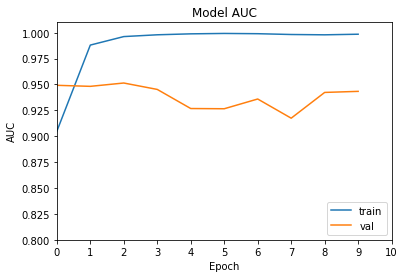

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.96      0.95      1779
      Racist       0.80      0.76      0.78       411

    accuracy                           0.92      2190
   macro avg       0.87      0.86      0.87      2190
weighted avg       0.92      0.92      0.92      2190

Test Accuracy: 94.08%
Test AUC: 85.89%


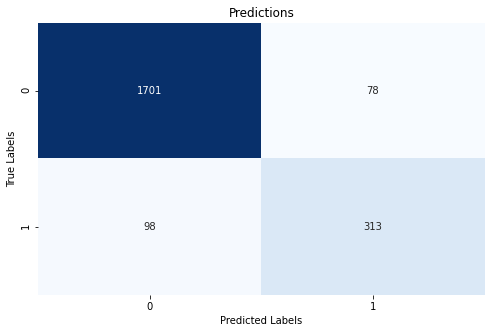

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 200-neurons LSTM.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(200, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_6 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 200)          365600    
_________________________________________________________________
conv1d_6 (Conv1D)            (None, 251, 32)           44832     
_________________________________________________________________
max_pooling1d_6 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_6 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_6 (Batch (None, 32)                128       
_________________________________________________________________
dense_16 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 29s 139ms/step - loss: 9.8762 - auc: 0.8024 - val_loss: 1.4326 - val_auc: 0.9114
Epoch 2/10
194/194 [==============================] - 26s 135ms/step - loss: 0.8826 - auc: 0.9785 - val_loss: 0.3927 - val_auc: 0.9491
Epoch 3/10
194/194 [==============================] - 26s 135ms/step - loss: 0.2207 - auc: 0.9955 - val_loss: 0.3521 - val_auc: 0.9444
Epoch 4/10
194/194 [==============================] - 26s 135ms/step - loss: 0.1656 - auc: 0.9976 - val_loss: 0.3551 - val_auc: 0.9177
Epoch 5/10
194/194 [==============================] - 26s 135ms/step - loss: 0.1415 - auc: 0.9973 - val_loss: 0.3749 - val_auc: 0.9296
Epoch 6/10
194/194 [==============================] - 26s 135ms/step - loss: 0.1260 - auc: 0.9979 - val_loss: 0.3588 - val_auc: 0.9331
Epoch 7/10
194/194 [==============================] - 26s 136ms/step - loss: 0.1115 - auc: 0.9984 - val_loss: 0.3563 - val_auc: 0.9297
Epoch 8/10
194/194 [==============================] - 2

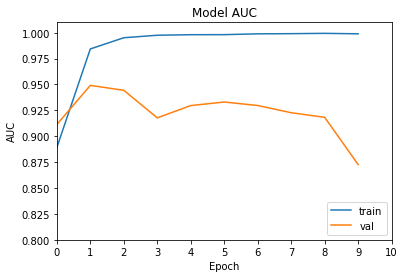

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.93      0.96      0.95      1779
      Racist       0.81      0.69      0.74       411

    accuracy                           0.91      2190
   macro avg       0.87      0.83      0.84      2190
weighted avg       0.91      0.91      0.91      2190

Test Accuracy: 89.45%
Test AUC: 82.52%


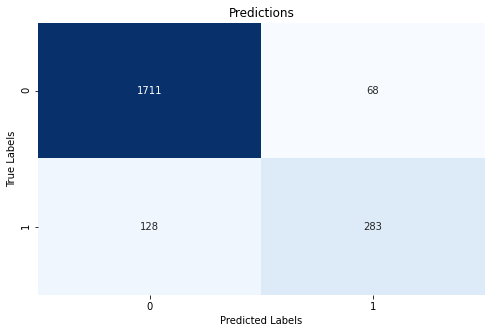

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Conclusion:
100-neurons LSTM showed the highest AUC validation of 0.9558 after 4 ephocs.


# Experimenting with different learning rate values

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_7 (Conv1D)            (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_7 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_7 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dense_19 (Dense)             (None, 64)               

### 0.1 learning rate.

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.1), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 27s 125ms/step - loss: 2.0996 - auc: 0.8235 - val_loss: 1.1652 - val_auc: 0.9122
Epoch 2/10
194/194 [==============================] - 24s 122ms/step - loss: 0.8837 - auc: 0.9585 - val_loss: 2.8665 - val_auc: 0.8030
Epoch 3/10
194/194 [==============================] - 24s 122ms/step - loss: 2.4612 - auc: 0.9327 - val_loss: 0.8354 - val_auc: 0.8895
Epoch 4/10
194/194 [==============================] - 24s 122ms/step - loss: 0.8552 - auc: 0.9657 - val_loss: 0.7015 - val_auc: 0.8985
Epoch 5/10
194/194 [==============================] - 24s 122ms/step - loss: 1.6079 - auc: 0.9585 - val_loss: 0.8451 - val_auc: 0.8722
Epoch 6/10
194/194 [==============================] - 24s 122ms/step - loss: 1.4862 - auc: 0.9413 - val_loss: 0.8408 - val_auc: 0.8597
Epoch 7/10
194/194 [==============================] - 24s 122ms/step - loss: 0.5501 - auc: 0.9758 - val_loss: 2.0334 - val_auc: 0.8661
Epoch 8/10
194/194 [==============================] - 2

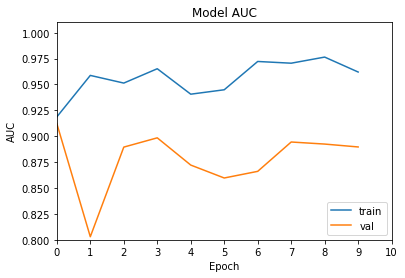

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.90      0.95      0.92      1779
      Racist       0.71      0.52      0.60       411

    accuracy                           0.87      2190
   macro avg       0.80      0.74      0.76      2190
weighted avg       0.86      0.87      0.86      2190

Test Accuracy: 87.65%
Test AUC: 73.59%


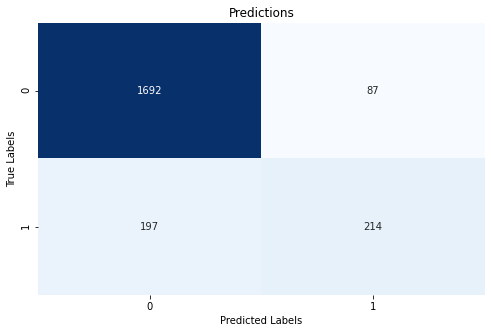

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 0.01 learning rate.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_8 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_8 (Conv1D)            (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_8 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_8 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_8 (Batch (None, 32)                128       
_________________________________________________________________
dense_22 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 26s 126ms/step - loss: 2.7520 - auc: 0.9028 - val_loss: 0.2944 - val_auc: 0.9638
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1532 - auc: 0.9946 - val_loss: 0.3419 - val_auc: 0.9386
Epoch 3/10
194/194 [==============================] - 24s 122ms/step - loss: 0.0999 - auc: 0.9982 - val_loss: 0.3797 - val_auc: 0.9271
Epoch 4/10
194/194 [==============================] - 24s 122ms/step - loss: 0.0698 - auc: 0.9995 - val_loss: 0.2819 - val_auc: 0.9583
Epoch 5/10
194/194 [==============================] - 24s 123ms/step - loss: 0.0700 - auc: 0.9993 - val_loss: 0.3966 - val_auc: 0.9004
Epoch 6/10
194/194 [==============================] - 24s 122ms/step - loss: 0.2172 - auc: 0.9976 - val_loss: 0.4056 - val_auc: 0.9497
Epoch 7/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1061 - auc: 0.9991 - val_loss: 0.2761 - val_auc: 0.9328
Epoch 8/10
194/194 [==============================] - 2

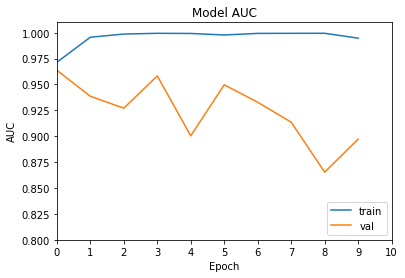

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.93      0.98      0.95      1779
      Racist       0.89      0.66      0.76       411

    accuracy                           0.92      2190
   macro avg       0.91      0.82      0.86      2190
weighted avg       0.92      0.92      0.92      2190

Test Accuracy: 92.24%
Test AUC: 82.13%


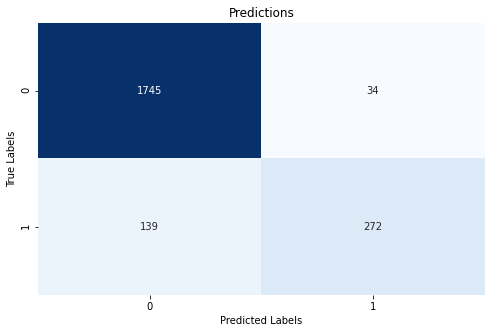

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 0.001 learning rate.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_9 (Embedding)      (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_9 (Conv1D)            (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_9 (Glob (None, 32)                0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 32)                128       
_________________________________________________________________
dense_25 (Dense)             (None, 64)               

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.001), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 27s 126ms/step - loss: 10.2358 - auc: 0.8076 - val_loss: 1.4484 - val_auc: 0.9487
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 0.8577 - auc: 0.9887 - val_loss: 0.3877 - val_auc: 0.9509
Epoch 3/10
194/194 [==============================] - 24s 122ms/step - loss: 0.2134 - auc: 0.9959 - val_loss: 0.3405 - val_auc: 0.9577
Epoch 4/10
194/194 [==============================] - 24s 122ms/step - loss: 0.1595 - auc: 0.9986 - val_loss: 0.3726 - val_auc: 0.9371
Epoch 5/10
194/194 [==============================] - 24s 122ms/step - loss: 0.1361 - auc: 0.9985 - val_loss: 0.3679 - val_auc: 0.9311
Epoch 6/10
194/194 [==============================] - 24s 122ms/step - loss: 0.1180 - auc: 0.9997 - val_loss: 0.3715 - val_auc: 0.9365
Epoch 7/10
194/194 [==============================] - 24s 123ms/step - loss: 0.1082 - auc: 0.9990 - val_loss: 0.3489 - val_auc: 0.9461
Epoch 8/10
194/194 [==============================] - 

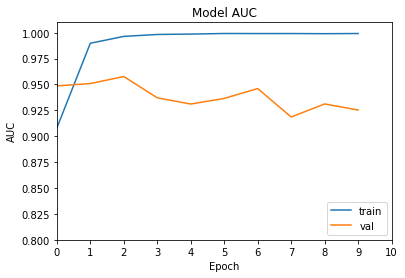

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.94      0.96      0.95      1779
      Racist       0.81      0.74      0.78       411

    accuracy                           0.92      2190
   macro avg       0.88      0.85      0.86      2190
weighted avg       0.92      0.92      0.92      2190

Test Accuracy: 92.36%
Test AUC: 85.23%


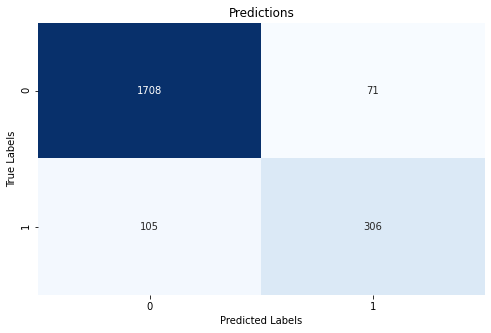

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### 0.0001 learning rate.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_10 (Embedding)     (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_10 (Conv1D)           (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_10 (MaxPooling (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_10 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 32)                128       
_________________________________________________________________
dense_28 (Dense)             (None, 64)              

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.Adam(lr=0.0001), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 26s 125ms/step - loss: 15.3834 - auc: 0.5634 - val_loss: 12.9724 - val_auc: 0.8124
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 12.2099 - auc: 0.8055 - val_loss: 10.2885 - val_auc: 0.8771
Epoch 3/10
194/194 [==============================] - 24s 122ms/step - loss: 9.6814 - auc: 0.8939 - val_loss: 8.1258 - val_auc: 0.9041
Epoch 4/10
194/194 [==============================] - 24s 122ms/step - loss: 7.6391 - auc: 0.9359 - val_loss: 6.3933 - val_auc: 0.9174
Epoch 5/10
194/194 [==============================] - 24s 122ms/step - loss: 5.9867 - auc: 0.9561 - val_loss: 5.9294 - val_auc: 0.8807
Epoch 6/10
194/194 [==============================] - 24s 123ms/step - loss: 4.7776 - auc: 0.8816 - val_loss: 3.9477 - val_auc: 0.9206
Epoch 7/10
194/194 [==============================] - 24s 123ms/step - loss: 3.6222 - auc: 0.9654 - val_loss: 3.0592 - val_auc: 0.9289
Epoch 8/10
194/194 [==============================]

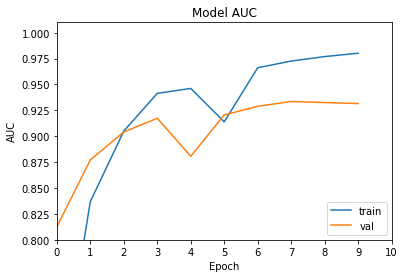

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.94      0.93      0.93      1779
      Racist       0.70      0.74      0.72       411

    accuracy                           0.89      2190
   macro avg       0.82      0.84      0.83      2190
weighted avg       0.90      0.89      0.89      2190

Test Accuracy: 92.48%
Test AUC: 83.51%


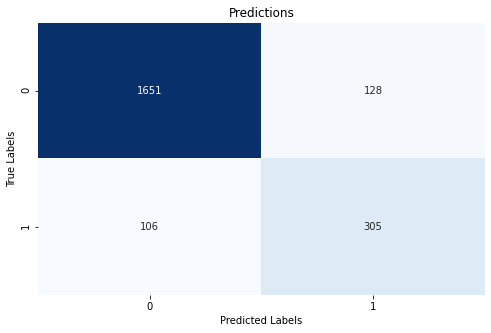

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Conclusion:
0.01 learning rate showed the highest validation AUC scores.

# Experimenting with different loss functions

### Hinge Loss.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_11 (Conv1D)           (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_11 (MaxPooling (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_11 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
dense_31 (Dense)             (None, 64)              

In [ ]:
model.compile(loss='hinge', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 27s 126ms/step - loss: 3.1236 - auc: 0.8831 - val_loss: 0.9465 - val_auc: 0.9646
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 0.5909 - auc: 0.9898 - val_loss: 0.9274 - val_auc: 0.9416
Epoch 3/10
194/194 [==============================] - 24s 122ms/step - loss: 0.5645 - auc: 0.9940 - val_loss: 0.9253 - val_auc: 0.9357
Epoch 4/10
194/194 [==============================] - 24s 124ms/step - loss: 0.5639 - auc: 0.9920 - val_loss: 0.9073 - val_auc: 0.9578
Epoch 5/10
194/194 [==============================] - 24s 123ms/step - loss: 0.5492 - auc: 0.9936 - val_loss: 0.9848 - val_auc: 0.9229
Epoch 6/10
194/194 [==============================] - 24s 123ms/step - loss: 0.6033 - auc: 0.9956 - val_loss: 0.9304 - val_auc: 0.8709
Epoch 7/10
194/194 [==============================] - 24s 124ms/step - loss: 0.5563 - auc: 0.9964 - val_loss: 0.9977 - val_auc: 0.8642
Epoch 8/10
194/194 [==============================] - 2

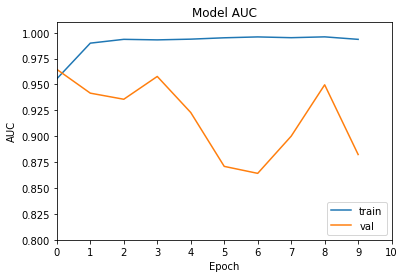

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.96      0.97      0.96      1779
      Racist       0.85      0.80      0.83       411

    accuracy                           0.94      2190
   macro avg       0.90      0.89      0.89      2190
weighted avg       0.94      0.94      0.94      2190

Test Accuracy: 89.26%
Test AUC: 88.52%


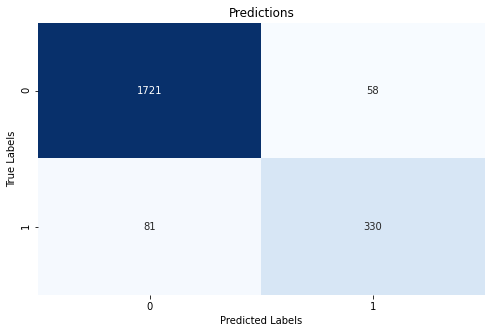

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Squared-Hinge Loss.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_12 (Embedding)     (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_12 (Conv1D)           (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_12 (MaxPooling (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_12 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
dense_34 (Dense)             (None, 64)              

In [ ]:
model.compile(loss='squared_hinge', optimizer=keras.optimizers.Adam(lr=0.01), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 27s 127ms/step - loss: 3.1165 - auc: 0.9079 - val_loss: 1.0380 - val_auc: 0.9543
Epoch 2/10
194/194 [==============================] - 24s 123ms/step - loss: 0.6141 - auc: 0.9905 - val_loss: 0.9717 - val_auc: 0.8701
Epoch 3/10
194/194 [==============================] - 24s 124ms/step - loss: 0.5798 - auc: 0.9932 - val_loss: 0.9855 - val_auc: 0.9133
Epoch 4/10
194/194 [==============================] - 24s 124ms/step - loss: 0.5888 - auc: 0.9929 - val_loss: 0.9674 - val_auc: 0.8769
Epoch 5/10
194/194 [==============================] - 24s 123ms/step - loss: 0.5687 - auc: 0.9930 - val_loss: 0.9517 - val_auc: 0.9596
Epoch 6/10
194/194 [==============================] - 24s 123ms/step - loss: 0.5480 - auc: 0.9959 - val_loss: 1.1860 - val_auc: 0.7795
Epoch 7/10
194/194 [==============================] - 24s 124ms/step - loss: 0.5701 - auc: 0.9963 - val_loss: 0.9612 - val_auc: 0.9397
Epoch 8/10
194/194 [==============================] - 2

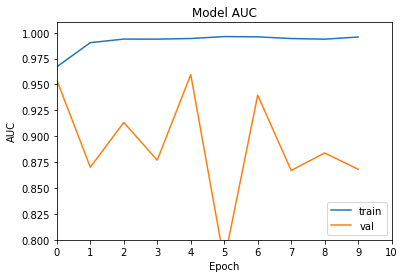

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.98      0.96      1779
      Racist       0.88      0.77      0.82       411

    accuracy                           0.94      2190
   macro avg       0.91      0.87      0.89      2190
weighted avg       0.93      0.94      0.93      2190

Test Accuracy: 89.15%
Test AUC: 87.11%


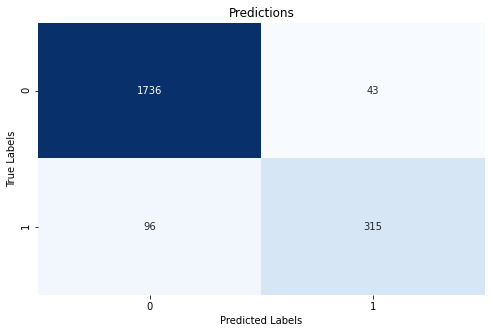

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Conclusion:
The binary_crossentropy loss showed the highest validation AUC scores.

# Experimenting with a different optimizer

### SGD Optimizer.

In [ ]:
# Deep Learning model (LSTM, CNN)
model = Sequential()


model.add(Embedding(vocab_size + 1, embedding_dim, weights=[embedding_matrix], input_length=max_len, trainable=True))


model.add(LSTM(100, return_sequences=True, name='lstm_layer1'))#,kernel_regularizer=l2(0.01),recurrent_regularizer=l2(0.01)))
model.add(Conv1D(filters=32, kernel_size=7, padding='same', activation='relu'))#,kernel_regularizer=l2(0.01),bias_regularizer=l2(0.01)))
model.add(MaxPooling1D(3)) # to reduce network size
model.add(GlobalMaxPooling1D())
model.add(BatchNormalization()) # to reduce weights

model.add(Dense(64, activation='relu',kernel_regularizer=l2(0.17),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu',kernel_regularizer=l2(0.19),bias_regularizer=l2(0.01)))
model.add(Dropout(0.3))
# model.add(Dense(16, kernel_regularizer=l2(0.001), activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))
model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_13 (Embedding)     (None, 251, 256)          9768192   
_________________________________________________________________
lstm_layer1 (LSTM)           (None, 251, 100)          142800    
_________________________________________________________________
conv1d_13 (Conv1D)           (None, 251, 32)           22432     
_________________________________________________________________
max_pooling1d_13 (MaxPooling (None, 83, 32)            0         
_________________________________________________________________
global_max_pooling1d_13 (Glo (None, 32)                0         
_________________________________________________________________
batch_normalization_13 (Batc (None, 32)                128       
_________________________________________________________________
dense_37 (Dense)             (None, 64)              

In [ ]:
model.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(lr=0.01), metrics=['AUC'])

In [ ]:
# to Train the model
history = model.fit(processed_x_train,y_train_upsampled, validation_data=(processed_x_val,y_val),epochs=10,batch_size=64,verbose=1)

Epoch 1/10
194/194 [==============================] - 8s 34ms/step - loss: 12.0648 - auc: 0.5952 - val_loss: 4.5258 - val_auc: 0.7913
Epoch 2/10
194/194 [==============================] - 6s 30ms/step - loss: 3.4601 - auc: 0.7590 - val_loss: 1.6382 - val_auc: 0.8262
Epoch 3/10
194/194 [==============================] - 6s 32ms/step - loss: 1.3536 - auc: 0.8166 - val_loss: 0.8999 - val_auc: 0.8483
Epoch 4/10
194/194 [==============================] - 6s 32ms/step - loss: 0.8189 - auc: 0.8417 - val_loss: 0.6817 - val_auc: 0.8652
Epoch 5/10
194/194 [==============================] - 6s 31ms/step - loss: 0.6645 - auc: 0.8599 - val_loss: 0.6082 - val_auc: 0.8769
Epoch 6/10
194/194 [==============================] - 6s 33ms/step - loss: 0.6116 - auc: 0.8640 - val_loss: 0.5817 - val_auc: 0.8845
Epoch 7/10
194/194 [==============================] - 6s 30ms/step - loss: 0.5755 - auc: 0.8782 - val_loss: 0.5520 - val_auc: 0.8907
Epoch 8/10
194/194 [==============================] - 6s 31ms/step -

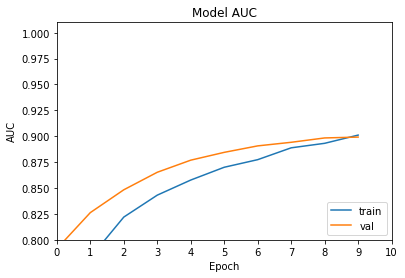

In [ ]:
plt.plot(history.history['auc'])
plt.plot(history.history['val_auc'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
y_pred = model.predict(processed_x_test)
label = np.round(y_pred)

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(processed_x_test,y_test, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.95      0.82      0.88      1779
      Racist       0.51      0.79      0.62       411

    accuracy                           0.82      2190
   macro avg       0.73      0.81      0.75      2190
weighted avg       0.86      0.82      0.83      2190

Test Accuracy: 88.17%
Test AUC: 80.89%


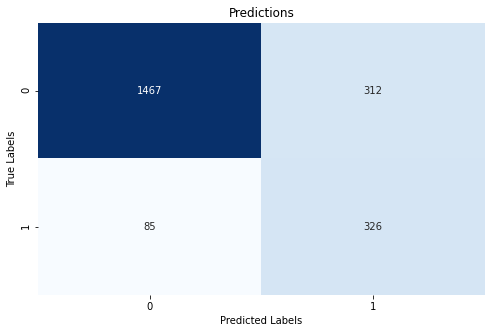

In [ ]:
from sklearn.metrics import plot_confusion_matrix, confusion_matrix

# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

### Conclusion:
The Adam optimized showed higher AUC validation scores.

#Pretrained Deep Learning Model "Bert"

In [ ]:
!pip install transformers
!git clone https://github.com/aub-mind/arabert.git
!pip install farasapy

fatal: destination path 'arabert' already exists and is not an empty directory.


In [ ]:
from transformers import BertTokenizer, TFBertForSequenceClassification
from transformers import InputExample, InputFeatures

In [ ]:
# 70% - traning 20% - Testing - 10% Validation
Data = pd.DataFrame(columns = ['DATA_COLUMN', 'LABEL_COLUMN'])
Data['DATA_COLUMN']  = df['Cleaned_4']
Data['LABEL_COLUMN'] = df['Label']

train, test = train_test_split(Data,
                                    test_size=0.2,
                                    random_state=0)
train, val = train_test_split(train,
                            test_size=0.125,
                            random_state=0)

In [ ]:
print(len(train))
print(len(test))
print(len(val))

7665
2190
1095


In [ ]:
# Reference (the paper of Bert, artical link)
def convert_data_to_examples(train, test, val, DATA_COLUMN, LABEL_COLUMN):
  train_InputExamples = train.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  test_InputExamples = test.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  validation_InputExamples = val.apply(lambda x: InputExample(guid=None, # Globally unique ID for bookkeeping, unused in this case
                                                          text_a = x[DATA_COLUMN],
                                                          text_b = None,
                                                          label = x[LABEL_COLUMN]), axis = 1)

  return train_InputExamples, test_InputExamples,validation_InputExamples

  train_InputExamples, validation_InputExamples = convert_data_to_examples(train,
                                                                           test,
                                                                           val,
                                                                           'DATA_COLUMN',
                                                                           'LABEL_COLUMN')
def convert_examples_to_tf_dataset(examples, tokenizer, max_length=128):
    features = [] # -> will hold InputFeatures to be converted later

    for e in examples:

        input_dict = tokenizer.encode_plus(
            e.text_a,
            add_special_tokens=True,
            max_length=max_length, # truncates if len(s) > max_length
            return_token_type_ids=True,
            return_attention_mask=True,
            padding='max_length', # pads to the right by default # CHECK THIS for pad_to_max_length
            truncation=True
        )

        input_ids, token_type_ids, attention_mask = (input_dict["input_ids"],
            input_dict["token_type_ids"], input_dict['attention_mask'])

        features.append(
            InputFeatures(
                input_ids=input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids, label=e.label
            )
        )

    def gen():
        for f in features:
            yield (
                {
                    "input_ids": f.input_ids,
                    "attention_mask": f.attention_mask,
                    "token_type_ids": f.token_type_ids,
                },
                f.label,
            )

    return tf.data.Dataset.from_generator(
        gen,
        ({"input_ids": tf.int32, "attention_mask": tf.int32, "token_type_ids": tf.int32}, tf.int64),
        (
            {
                "input_ids": tf.TensorShape([None]),
                "attention_mask": tf.TensorShape([None]),
                "token_type_ids": tf.TensorShape([None]),
            },
            tf.TensorShape([]),
        ),
    )


DATA_COLUMN = 'DATA_COLUMN'
LABEL_COLUMN = 'LABEL_COLUMN'

In [ ]:
model = TFBertForSequenceClassification.from_pretrained("aubmindlab/bert-base-arabert")
tokenizer = BertTokenizer.from_pretrained("aubmindlab/bert-base-arabert")

All model checkpoint layers were used when initializing TFBertForSequenceClassification.

Some layers of TFBertForSequenceClassification were not initialized from the model checkpoint at aubmindlab/bert-base-arabert and are newly initialized: ['classifier']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# converting the Data into examples and split them intp patchs
train_InputExamples, test_InputExamples, validation_InputExamples = convert_data_to_examples(train, test, val, DATA_COLUMN, LABEL_COLUMN)

train_data = convert_examples_to_tf_dataset(list(train_InputExamples), tokenizer)
train_data = train_data.batch(32)

test_data = convert_examples_to_tf_dataset(list(test_InputExamples), tokenizer)
test_data = test_data.batch(32)

validation_data = convert_examples_to_tf_dataset(list(validation_InputExamples), tokenizer)
validation_data = validation_data.batch(32)

In [ ]:
# compiling and traning for the last layer (result layer) of the Arbert (transfering learning technique)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=3e-5, epsilon=1e-08, clipnorm=1.0),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy('AUC')])

history = model.fit(train_data, epochs=10, validation_data=validation_data, verbose=2)

Epoch 1/10
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: module, class, method, function, traceback, frame, or code object was expected, got cython_function_or_method
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Cause: while/else statement not yet supported
To silence this warning, decorate the function with @tf.autog

In [ ]:
# tf_batch = tokenizer(X_test.to_list()[:1000], max_length=128, padding=True, truncation=True, return_tensors='tf')
# tf_outputs = model(tf_batch)
# tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
# label = tf.argmax(tf_predictions, axis=1)
# label = label.numpy()
# y_pred = []
# for i in range(len(X_test[:1000])):
#   y_pred.append(label[i])

In [ ]:
# tf_batch = tokenizer(X_test.to_list()[1000:], max_length=128, padding=True, truncation=True, return_tensors='tf')
# tf_outputs = model(tf_batch)
# tf_predictions = tf.nn.softmax(tf_outputs[0], axis=-1)
# label = tf.argmax(tf_predictions, axis=1)
# label = label.numpy()
# for i in range(len(X_test[1000:])):
#   y_pred.append(label[i])

In [ ]:
tf_predictions = tf.nn.softmax(y_pred[0], axis=-1)
label = tf.argmax(tf_predictions, axis=1)

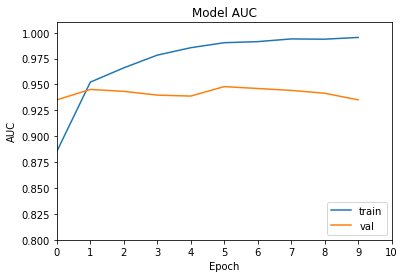

In [ ]:
plt.plot(history.history['AUC'])
plt.plot(history.history['val_AUC'])
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(['train', 'val'], loc='lower right')
plt.ylim([0.8, 1.01])
plt.xticks([i for i in range(11)])
plt.xlim([0, 10])
plt.show()

In [ ]:
# Metrics
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix
from sklearn.metrics import classification_report
target_names = ['Not Racist', 'Racist']
print(classification_report(y_test, label, target_names=target_names))

print(f"Test Accuracy: {model.evaluate(test_data, verbose=0)[1]*100:.2f}%")
print(f"Test AUC: {metrics.roc_auc_score(y_test, label)*100:.2f}%")

              precision    recall  f1-score   support

  Not Racist       0.99      0.94      0.96      1779
      Racist       0.79      0.95      0.86       411

    accuracy                           0.94      2190
   macro avg       0.89      0.94      0.91      2190
weighted avg       0.95      0.94      0.94      2190

Test Accuracy: 94.20%
Test AUC: 94.37%


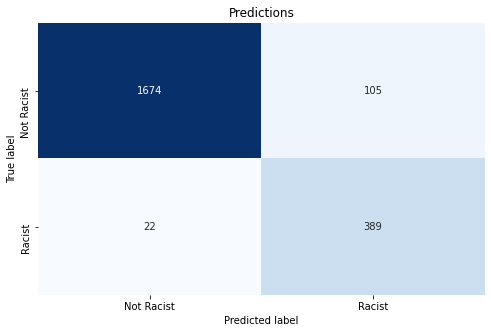

In [ ]:
# Creates a confusion matrix
cm = confusion_matrix(y_test, label)
# Transform to df for easier plotting
cm_df = pd.DataFrame(cm,
                     index = target_names,
                     columns = target_names)
plt.figure(figsize=(8,5))
sns.heatmap(cm_df, annot=True, fmt='g', cmap=plt.cm.Blues, cbar=False)
plt.rcParams['font.size'] = 10
plt.title('Predictions')
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()